In [1]:
from datetime import datetime
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import time

import mpl_finance as mpf
from matplotlib import ticker
import matplotlib.dates as mdates
from pyti.exponential_moving_average import exponential_moving_average as ema
from pyti.moving_average_convergence_divergence import moving_average_convergence_divergence as macd
from pyti.simple_moving_average import simple_moving_average as sma
import talib as ta

gc.enable()

## SQL

In [2]:
dbname = "C:/Users/goomo/Desktop/FX_ProtoType/DB/USD_JPY.db"
conn = sqlite3.connect(dbname)
cur = conn.cursor()

In [3]:
df = pd.read_sql('SELECT * FROM H1 WHERE Date>2005', conn)
cur.close()
conn.close()

# 日付・曜日追加

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
# 曜日(0=日曜日、1=月曜日)を数値で取得
df['Day of The Week'] = df['Date'].dt.dayofweek
df['Hour'] = df['Date'].dt.hour
df['Week'] = df['Date'].dt.week

In [6]:
df.head()

,index,Date,Open,High,Low,Close,Volume,Year,Month,Day,Day of The Week,Hour,Week
0,836,2005-01-02 18:00:00,102.54,102.54,102.49,102.51,5,2005,1,2,6,18,53
1,837,2005-01-02 19:00:00,102.58,102.73,102.56,102.69,56,2005,1,2,6,19,53
2,838,2005-01-02 20:00:00,102.68,102.77,102.66,102.73,130,2005,1,2,6,20,53
3,839,2005-01-02 21:00:00,102.73,102.77,102.69,102.72,91,2005,1,2,6,21,53
4,840,2005-01-02 22:00:00,102.71,102.73,102.61,102.63,75,2005,1,2,6,22,53


In [7]:
df = df.drop('index', axis=1)
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

In [8]:
df.head(3)

,Open,High,Low,Close,Volume,Year,Month,Day,Day of The Week,Hour,Week
Date,,,,,,,,,,,
2005-01-02 18:00:00,102.54,102.54,102.49,102.51,5,2005,1,2,6,18,53
2005-01-02 19:00:00,102.58,102.73,102.56,102.69,56,2005,1,2,6,19,53
2005-01-02 20:00:00,102.68,102.77,102.66,102.73,130,2005,1,2,6,20,53


# クラス定義

### チャート

In [9]:
def candlechart(data, width=0.8):
    fig, ax = plt.subplots(figsize=(20, 7))
    # ローソク足
    mpf.candlestick2_ohlc(ax, opens=data[:,0], closes=data[:,3],
                          lows=data[:,2], highs=data[:,1],
                          width=width, colorup='r', colordown='b')

    xdate = data[:,8]
    ax.xaxis.set_major_locator(ticker.MaxNLocator(6))

    def mydate(x, pos):
        try:
            return xdate[int(x)]
        except IndexError:
            return ''

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

    fig.autofmt_xdate()
    fig.tight_layout()

    return fig, ax

# 準備

### テクニカル指標追加

In [10]:
WINDOW_LEN_1DAY   = 24

In [11]:
df = df.reset_index()

In [12]:
df.head(2)

,Date,Open,High,Low,Close,Volume,Year,Month,Day,Day of The Week,Hour,Week
0,2005-01-02 18:00:00,102.54,102.54,102.49,102.51,5,2005,1,2,6,18,53
1,2005-01-02 19:00:00,102.58,102.73,102.56,102.69,56,2005,1,2,6,19,53


In [13]:
df['AFTER_1DAY'] = df['Close'].shift(-24)

### 各日付の価格差

In [14]:
DIFF_1D  = []
for i in range(len(df)):

    DIFF_1D.append((df['AFTER_1DAY'][i] - df['Close'][i]))

    
DIFF_1D   = pd.DataFrame({'DIFF_AFTER_1D':DIFF_1D})

df = pd.concat([df, DIFF_1D],axis=1)

In [15]:
df.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Day,Day of The Week,Hour,Week,AFTER_1DAY,DIFF_AFTER_1D
0,2005-01-02 18:00:00,102.54,102.54,102.49,102.51,5,2005,1,2,6,18,53,102.845,0.335
1,2005-01-02 19:00:00,102.58,102.73,102.56,102.69,56,2005,1,2,6,19,53,102.685,-0.005
2,2005-01-02 20:00:00,102.68,102.77,102.66,102.73,130,2005,1,2,6,20,53,102.705,-0.025
3,2005-01-02 21:00:00,102.73,102.77,102.69,102.72,91,2005,1,2,6,21,53,102.795,0.075
4,2005-01-02 22:00:00,102.71,102.73,102.61,102.63,75,2005,1,2,6,22,53,102.835,0.205


In [16]:
print(df['DIFF_AFTER_1D'].describe())

count    89864.000000
mean         0.001573
std          0.638886
min         -6.104000
25%         -0.326000
50%          0.010500
75%          0.356250
max          6.490000
Name: DIFF_AFTER_1D, dtype: float64


C:\Users\goomo\Anaconda3\envs\gpu\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\goomo\Anaconda3\envs\gpu\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([4.0000e+00, 4.5000e+01, 2.9800e+02, 3.7190e+03, 5.3951e+04,
        3.0470e+04, 1.2740e+03, 9.3000e+01, 8.0000e+00, 2.0000e+00]),
 array([-6.104 , -4.8446, -3.5852, -2.3258, -1.0664,  0.193 ,  1.4524,
         2.7118,  3.9712,  5.2306,  6.49  ]),
 <a list of 10 Patch objects>)

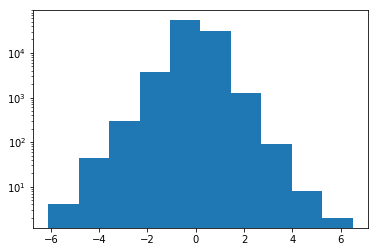

In [17]:
plt.hist(df['DIFF_AFTER_1D'], log=True)

## 利確・損切を考慮した分類

In [18]:
def Profit_Classification_2(df, _DiffDay, window_len):    
    profit   = []
    for i in range(len(df) - window_len):
        if _DiffDay[i] > 0:
            profit.append('1')
        else:
            profit.append('0')
              
    return profit

In [19]:
%%time
windows = 24
profit = Profit_Classification_2(df, df['DIFF_AFTER_1D'], windows)

Wall time: 496 ms


In [20]:
PROFIT_1D  = pd.DataFrame({'PROFIT_1D':profit})
df = pd.concat([df, PROFIT_1D],axis=1)

In [23]:
df.head(3)

,Date,Open,High,Low,Close,Volume,Year,Month,Day,Day of The Week,Hour,Week,AFTER_1DAY,DIFF_AFTER_1D,PROFIT_1D
0,2005-01-02 18:00:00,102.54,102.54,102.49,102.51,5,2005,1,2,6,18,53,102.845,0.335,1
1,2005-01-02 19:00:00,102.58,102.73,102.56,102.69,56,2005,1,2,6,19,53,102.685,-0.005,0
2,2005-01-02 20:00:00,102.68,102.77,102.66,102.73,130,2005,1,2,6,20,53,102.705,-0.025,0


In [24]:
print(df['PROFIT_1D'].value_counts(ascending=True))

0    44127
1    45737
Name: PROFIT_1D, dtype: int64


## 前処理（学習と検証用にデータ加工）

In [25]:
df["Date"] = pd.to_datetime(df["Date"])
df1 = df[df["Date"] > datetime(2010, 1, 1)]

In [26]:
df1.shape

(57695, 15)

In [27]:
df1.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Year', 'Month',
       'Day', 'Day of The Week', 'Hour', 'Week', 'AFTER_1DAY', 'DIFF_AFTER_1D',
       'PROFIT_1D'],
      dtype='object')

In [28]:
split_date = '2018/01/01 00:00:00'
train, test = df1[df1['Date'] < split_date], df1[df1['Date']>=split_date]

In [29]:
test = test[:-24]

In [30]:
test.tail(3)

,Date,Open,High,Low,Close,Volume,Year,Month,Day,Day of The Week,Hour,Week,AFTER_1DAY,DIFF_AFTER_1D,PROFIT_1D
89861,2019-01-15 12:00:00,108.379,108.508,108.334,108.508,1386,2019,1,15,1,12,3,108.854,0.346,1
89862,2019-01-15 13:00:00,108.506,108.584,108.332,108.361,1799,2019,1,15,1,13,3,108.809,0.448,1
89863,2019-01-15 14:00:00,108.358,108.527,108.351,108.483,1741,2019,1,15,1,14,3,108.823,0.340,1


In [31]:
XX = ['Open', 'High', 'Low', 'Close', 'Volume','Year', 'Month','Day', 'Day of The Week', 'Hour']

XX_train = train.loc[:,XX]
X_train = np.array(train.loc[:,XX])
X_test  = np.array(test.loc[:,XX])

In [32]:
XX_train.head(3)

,Open,High,Low,Close,Volume,Year,Month,Day,Day of The Week,Hour
32193,92.943,93.000,92.925,92.934,35,2010,1,3,6,18
32194,92.939,92.974,92.931,92.944,83,2010,1,3,6,19
32195,92.942,92.990,92.930,92.952,97,2010,1,3,6,20


In [33]:
y_train = np.array(train.loc[:,['PROFIT_1D']])
y_test  = np.array(test.loc[:,['PROFIT_1D']])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(51221, 10)
(51221, 1)
(6450, 10)
(6450, 1)


LSTMは、3次元データにしないといけない。
一回に読み込む時系列の係数を保持する。
24時間後を当てるために、24としたがあっているのか？
時間をfloatにして読み込ませることができるか？

In [34]:
window_len = 240        # 入力系列数
n_in = X_train.shape[1]   # 学習データ（＝入力）の列数
len_seq = X_train.shape[0] - window_len + 1
data = []

for i in range(0, len_seq):
    data.append(X_train[i:i+window_len, :])
X = np.array(data).reshape(len(data), window_len, n_in)

print(X.shape)

(50982, 240, 10)


In [35]:
window_len = 240            # 入力系列数
n_in = X_test.shape[1]   # 学習データ（＝入力）の列数
len_seq = X_test.shape[0] - window_len + 1
target = []

for i in range(0, len_seq):
    target.append(X_test[i:i+window_len, :])
T = np.array(target).reshape(len(target), window_len, n_in)

print(T.shape)

(6211, 240, 10)


In [36]:
yy_train = y_train[window_len -1 :X.shape[0] + window_len +1]
yy_test = y_test[window_len -1 :T.shape[0] + window_len +1]

In [37]:
X = X.astype(float)

In [38]:
T = T.astype(float)

In [39]:
print(X.shape)
print(T.shape)
print(yy_train.shape)
print(yy_test.shape)

(50982, 240, 10)
(6211, 240, 10)
(50982, 1)
(6211, 1)


## モデルの定義

In [40]:
size = 128
batchsize = 256
NCATS=1

In [110]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

model = MobileNet(input_shape=(size, size, 4), alpha=1., weights=None, classes=NCATS)
model.compile(optimizer=Adam(lr=0.1), loss='binary_crossentropy',
              metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 4)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 4)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        1152      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

In [42]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import cv2
import sys
from io import BytesIO
from PIL import Image
import gc

def candlechart(data, size,width=0.6):
#def candlechart(data, size,width=0.7):
    fig, ax = plt.subplots(figsize=(10, 4))
    #fig, ax = plt.subplots(figsize=(20, 7))
    # ローソク足
    mpf.candlestick2_ohlc(ax, opens=data[:,0], closes=data[:,3],
                          lows=data[:,2], highs=data[:,1],
                          width=width, colorup='r', colordown='b')

    xdate = data[:,8]
    ax.xaxis.set_major_locator(ticker.MaxNLocator(6))

    def mydate(x, pos):
        try:
            return xdate[int(x)]
        except IndexError:
            return ''

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    plt.close('all')
    
    imgdata = BytesIO()
    fig.savefig(imgdata, format='png')
    imgdata.seek(0)  # rewind the data
    im = Image.open(imgdata)
    imm = np.array(im)

    fig.clear()
    imgdata.close()
    #gc.collect()
    
    return cv2.resize(imm, (size, size))
 
def df_to_image_array_xd(df, size):
    xxx = []
    bbb = []
    for i, image in enumerate(df):
        xxx = candlechart(image,size=size)
        bbb.append(xxx)
    return bbb

In [43]:
%%time

x_valid = df_to_image_array_xd(T, size=size)
ss = np.array(x_valid)
print('Validation array memory {:.2f} GB'.format(ss.nbytes / 1024.**3))
gc.collect()

Validation array memory 0.38 GB
Wall time: 5min 34s


In [44]:
gc.collect()

1188196

In [142]:
import random
from numba import jit

def candlechart_1(data, size, i, batchsize, width=0.6):
            
    fig, ax = plt.subplots(figsize=(10, 4))

    mpf.candlestick2_ohlc(ax, opens=data[:,0], closes=data[:,3],
                          lows=data[:,2], highs=data[:,1],
                          width=width, colorup='r', colordown='b')

    xdate = data[:,8]
    ax.xaxis.set_major_locator(ticker.MaxNLocator(6))

    def mydate(x, pos):
        try:
            return xdate[int(x)]
        except IndexError:
            return ''

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    plt.close('all')
    
    imgdata = BytesIO()
    fig.savefig(imgdata, format='png')
    imgdata.seek(0)  # rewind the data
    im = Image.open(imgdata)
    imm = np.array(im)

    fig.clear()
    imgdata.close()
    if i == batchsize-1:
        del fig
        del im
        gc.collect()
    
    return cv2.resize(imm, (size, size))

@jit
def shuffle_samples(X, y, batchsize):
    xx = batchsize, X.shape[1], X.shape[2]
    yy = batchsize, y.shape[1]
    order = np.arange(X.shape[0])
    np.random.shuffle(order)
    #print(order)
    X_result = np.zeros(xx)
    y_result = np.zeros(yy)
    for i in range(batchsize):
        X_result[i, ...] = X[order[i], ...]
        y_result[i, ...] = y[order[i], ...]
    return X_result, y_result

In [46]:
def image_generator_xd(xz, yz, size, batchsize, NCATS):
    while True:
        xxx = []
        x = []
        y = []
        js, ks = shuffle_samples(xz,yz,batchsize)
        for j in range(0, batchsize):
            xxx = candlechart_1(js[j], size=size, i=j, batchsize=batchsize)
            x.append(xxx)
            y.append(ks[j])
        x = np.array(x)
        y = np.array(y)
        gc.collect()
        yield x, y

In [143]:
train_datagen = image_generator_xd(X, yy_train, size=size, batchsize=batchsize, NCATS = NCATS)

In [144]:
%%time
x, y = next(train_datagen)

Wall time: 32.2 s


Wall time: 10.6 s
Wall time: 19 s
Wall time: 5.31 s

In [138]:
print('Validation array memory {:.2f} MB'.format(x.nbytes / 1024.**2))
gc.collect()

Validation array memory 128.00 MB


321335

In [145]:
print(x.shape)
print(yy_train.shape)
print(ss.shape)
print(yy_test.shape)

(256, 128, 128, 4)
(50982, 1)
(6211, 128, 128, 4)
(6211, 1)


x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [139]:
%%time
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
STEPS=10

callbacks = [
    ReduceLROnPlateau(monitor='val_acc', factor=0.75, patience=3, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1),
    ModelCheckpoint('model.h5', monitor='val_acc', mode='max', save_best_only=True,
                    save_weights_only=True),
]

Wall time: 0 ns


In [140]:
%%time
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=20, verbose=1,
    validation_data=(ss, yy_test),
    shuffle=True,
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/20
10/10 [==============================] - 247s 25s/step - loss: 7.7968 - acc: 0.5109 - val_loss: 7.7610 - val_acc: 0.5120
Epoch 2/20
10/10 [==============================] - 155s 15s/step - loss: 7.8030 - acc: 0.5105 - val_loss: 7.7610 - val_acc: 0.5120
Epoch 3/20
10/10 [==============================] - 159s 16s/step - loss: 8.2078 - acc: 0.4852 - val_loss: 7.7610 - val_acc: 0.5120
Epoch 4/20
 2/10 [=====>........................] - ETA: 2:00 - loss: 8.5628 - acc: 0.4629

KeyboardInterrupt: 

In [146]:
gc.collect()

0

In [68]:
predicted = model.predict(ss)

In [71]:
print(predicted.shape)
print(predicted)

(6211, 1)
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [89]:
predict_proba = model.predict_proba(ss)
predict_classes = model.predict_classes(ss)

AttributeError: 'Model' object has no attribute 'predict_proba'

In [ ]:
print(np.max(predict_proba[20]))
print(predict_classes[20])

In [ ]:
predict_classes[0]

In [ ]:
predict_classes.shape

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(predict_classes)

In [ ]:
plt.hist(yy_test)

In [114]:
batchsize = 128
size = 128
import numba as jit

def image_generator_xd(x, y, size, batchsize, NCATS):
    while True:
        xx = []
        yy = []
        s = 1
        for i, (js, ks) in enumerate(zip(x, y)):
            xx.append(js)
            yy.append(ks)
            if i== batchsize*s:
                
                i = 0
                x = []
                y = []
                xxx = []
                for j in range(0, batchsize-1):
                    xxx = candlechart(xx[j], size=size)
                    x.append(xxx)
                    y.append(yy[j])
                    #del xxx
                    #gc.collect()
                x = np.array(x)
                y = np.array(y)
                s += 1
                yield x, y

In [115]:
batchsize = 128
size = 128
NCATS=13
train_datagen = image_generator_xd(X, y_binary_train, size=size, batchsize=batchsize, NCATS = NCATS)

In [116]:
gc.collect()

2456

In [117]:
%%time
x, y = next(train_datagen)

Wall time: 5.13 s
